# From Chaos to Clarity: Cleaning & Analyzing Real-world Messy Data

In [171]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# import data
df= pd.read_csv('dirty_cafe_sales.csv')

### Read data set

In [172]:
df.shape
df.head()
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Transaction ID    10000 non-null  object
 1   Item              9667 non-null   object
 2   Quantity          9862 non-null   object
 3   Price Per Unit    9821 non-null   object
 4   Total Spent       9827 non-null   object
 5   Payment Method    7421 non-null   object
 6   Location          6735 non-null   object
 7   Transaction Date  9841 non-null   object
dtypes: object(8)
memory usage: 625.1+ KB


,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
count,10000,9667,9862,9821,9827,7421,6735,9841
unique,10000,10,7,8,19,5,4,367
top,TXN_9226047,Juice,5,3.0,6.0,Digital Wallet,Takeaway,UNKNOWN
freq,1,1171,2013,2429,979,2291,3022,159


### Standardize column names

In [173]:
# df.head(10)
df.rename(columns={
    'Transaction ID':'id',
    'Price Per Unit':'price',
    'Total Spent':'total',
    'Payment Method':'pmethod',
    'Transaction Date':'date',
    'Item':'item',
    'Quantity':'quantity',
    'Location':'location',
    }, inplace=True)

# df.coulmns=df.columns.str.lower() # did not work
df.head()

,id,item,quantity,price,total,pmethod,location,date
0,TXN_1961373,Coffee,2,2.0,4.0,Credit Card,Takeaway,2023-09-08
1,TXN_4977031,Cake,4,3.0,12.0,Cash,In-store,2023-05-16
2,TXN_4271903,Cookie,4,1.0,ERROR,Credit Card,In-store,2023-07-19
3,TXN_7034554,Salad,2,5.0,10.0,UNKNOWN,UNKNOWN,2023-04-27
4,TXN_3160411,Coffee,2,2.0,4.0,Digital Wallet,In-store,2023-06-11


### Fix data types:

In [174]:
df.dtypes
df.quantity= pd.to_numeric(df.quantity,errors='coerce')
df.quantity.describe()
df.price= pd.to_numeric(df.price,errors='coerce')
df.total= pd.to_numeric(df.total,errors='coerce')
df.date = pd.to_datetime(df.date,errors='coerce')
df["month"] = df.date.dt.month
df["day"] = df.date.dt.day_of_week
df.describe()


,quantity,price,total,date,month,day
count,9521.000000,9467.000000,9498.000000,9540,9540.000000,9540.000000
mean,3.028463,2.949984,8.924352,2023-07-01 23:00:31.698113280,6.524004,3.014151
min,1.000000,1.000000,1.000000,2023-01-01 00:00:00,1.000000,0.000000
25%,2.000000,2.000000,4.000000,2023-04-01 00:00:00,4.000000,1.000000
50%,3.000000,3.000000,8.000000,2023-07-02 00:00:00,7.000000,3.000000
75%,4.000000,4.000000,12.000000,2023-10-02 00:00:00,10.000000,5.000000
max,5.000000,5.000000,25.000000,2023-12-31 00:00:00,12.000000,6.000000
std,1.419007,1.278450,6.009919,NaN,3.449446,2.002752


### Validatin and correctness

In [175]:
# df[df.id.duplicated()].sum()
# df = df.drop_duplicates()
# There is no duplicates


In [176]:
df[df.price <= 0]
df[df.quantity <= 0]
df[df.total < df.price * df.quantity]
# All is good

,id,item,quantity,price,total,pmethod,location,date,month,day


In [244]:
df[df.total != df.price*df.quantity] # there is error values in 1456 rows
df.loc[
    (df['quantity'].notnull()) &
    (df['price'].notnull()) &
    (df['total'].isnull()),
    'total'
] = df['price'] * df['quantity']
# we have fixed 475 rows
df[df.total != df.price * df.quantity] # 994 rows is remaining
#look where we can get price from total/quantity
df.loc[(df['quantity'].notnull()) & (df['price'].isnull()) & (df['total'].notnull())] # we found 495 rows

df.loc[
    (df['quantity'].notnull()) &
    (df['price'].isnull()) &
    (df['total'].notnull()),
    'price'
] = df['total'] / df['quantity']

#look where we can get quantity from total/price

df.loc[(df['quantity'].isnull()) & (df['price'].notnull()) & (df['total'].notnull())] # we found 441 rows

df.loc[
    (df['quantity'].isnull()) &
    (df['price'].notnull()) &
    (df['total'].notnull()),
    'quantity'
] = df['total'] / df['price']

# Finally we will look for all null then delete them
df.loc[(df['quantity'].isnull()) & (df['price'].isnull()) & (df['total'].isnull())] # we found 0 rows

# df.info()
df[df.total != df.price * df.quantity].shape # there is still 58 rows with 2 out of 3 is null

# find out the ones with price is null
df[(df.total != df.price * df.quantity)& (df.price.isnull())].shape # 38 rows we can fix
df[(df.total != df.price * df.quantity)& (df.price.isnull())]

# get the price and reassign it
df.groupby(['item','price']).price.count()
# Cake=3, Coffee=2, Cookie=1,Juice=3, Salad=5, Sandwich=4, Smoothie=4, Tea=1.5
prices = {"Cake": 3, "Coffee": 2, "Cookie": 1, "Juice": 3, "Salad": 5, "Sandwich": 4, "Smoothie": 4, "Tea": 1.5}
# I found out that i can solve ERROR and UNKNOWN in item ;)

df.loc[(df.total != df.price * df.quantity)& (df.price.isnull()),['item','price']]
df.loc[df['price'].isnull(), 'price'] = df.loc[df['price'].isnull(), 'item'].map(prices)
df.loc[(df.total != df.price * df.quantity)& (df.price.isnull()),['item','price']]
df[df.total != df.price * df.quantity].shape # now its 26 rows

# Its about time to fix items
df.loc[(df.item.isnull())| (df.item=='ERROR') | (df.item=='UNKNOWN')] # 969 rows

# Invert dictionary: price → item
price_to_item = {v: k for k, v in prices.items()}

# Fill missing/invalid items based on price
df.loc[
    (df['item'].isnull()) | (df['item'].isin(['ERROR', 'UNKNOWN'])),
    'item'
] = df.loc[
    (df['item'].isnull()) | (df['item'].isin(['ERROR', 'UNKNOWN'])),
    'price'
].map(price_to_item)

df.loc[(df.item.isnull())| (df.item=='ERROR') | (df.item=='UNKNOWN')] # now its 6 rows.


# lets fix payment method
df.groupby('pmethod').total.count() # ERROR	305, UNKNOWN	293
# df[df.pmethod.isnull()].shape # 2579 NaN
df['pmethod'].value_counts(normalize=True)
df[df['pmethod'].isna()].groupby('location')['total'].mean()

# best practice is to treat missing values as Unknown
df['pmethod'] = df['pmethod'].replace(['ERROR', 'UNKNOWN'], np.nan)
df['pmethod'] = df['pmethod'].fillna('Unknown')
df.groupby('pmethod').total.count() # Unknown	3169

# lets fix payment method
df.groupby('location').total.count() # ERROR	357, UNKNOWN	338
df[df.location.isnull()].shape # 3265 NaN
df['location'].value_counts(normalize=True)

df['location'] = df['location'].replace(['ERROR', 'UNKNOWN'], np.nan)
df['location'] = df['location'].fillna('Unknown')
df.groupby('location').total.count() # Unknown	3953

# Delete time

df[(df.pmethod=='Unknown')&(df.location=='Unknown')& df.date.isna()]


,id,item,quantity,price,total,pmethod,location,date,month,day
104,TXN_7447872,Juice,2.0,3.0,6.0,Unknown,Unknown,NaT,NaN,NaN
246,TXN_1908636,Tea,2.0,1.5,3.0,Unknown,Unknown,NaT,NaN,NaN
571,TXN_3810451,Juice,4.0,3.0,12.0,Unknown,Unknown,NaT,NaN,NaN
885,TXN_8868960,Salad,5.0,5.0,25.0,Unknown,Unknown,NaT,NaN,NaN
892,TXN_7675823,Tea,5.0,1.5,7.5,Unknown,Unknown,NaT,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
9713,TXN_3787941,Tea,2.0,1.5,3.0,Unknown,Unknown,NaT,NaN,NaN
9877,TXN_1964893,Smoothie,1.0,4.0,4.0,Unknown,Unknown,NaT,NaN,NaN
9931,TXN_8344810,Smoothie,2.0,4.0,8.0,Unknown,Unknown,NaT,NaN,NaN
9937,TXN_8253472,Cake,1.0,3.0,3.0,Unknown,Unknown,NaT,NaN,NaN


### Talk to the data

In [245]:
item_tpq=df.groupby('item')[['total','price','quantity']].agg(['sum','count']).sort_values(by=('total','sum'),ascending=False)
item_tpq

total         price       quantity      
              sum count     sum count      sum count
item                                                
Salad     19095.0  1270  6360.0  1272   3819.0  1270
Smoothie  16160.0  1321  5292.0  1323   4040.0  1321
Sandwich  13716.0  1127  4524.0  1131   3429.0  1127
Juice     12786.0  1415  4254.0  1418   4262.0  1415
Cake      10404.0  1138  3417.0  1139   3468.0  1138
Coffee     7808.0  1286  2582.0  1291   3904.0  1286
Tea        5475.0  1206  1810.5  1207   3650.0  1206
Cookie     3598.0  1211  1213.0  1213   3598.0  1211

Here we can see that the most sold item is **Juice**, and the least one is **Tea**, while on money scale the best income item is **Salad** while **Cookie** is the least.

In [252]:
df.groupby('pmethod').total.sum().sort_values(ascending=False)

,total
pmethod,
Unknown,27813.5
Credit Card,20466.0
Digital Wallet,20414.0
Cash,20402.5


Here we can tell that all payment methods are almost the same.

In [253]:
df.groupby('location').total.sum().sort_values(ascending=False)

,total
location,
Unknown,35369.5
In-store,27174.0
Takeaway,26552.5


Here we notice that the location didn't make a quit change in total income.

In [254]:
df.groupby(['location','pmethod'])[['total','quantity']].sum()

total  quantity
location pmethod                          
In-store Cash             6388.0    2101.0
         Credit Card      6009.0    2051.0
         Digital Wallet   6552.5    2150.0
         Unknown          8224.5    2831.0
Takeaway Cash             5901.0    2049.0
         Credit Card      5921.0    2005.0
         Digital Wallet   6291.5    2204.0
         Unknown          8439.0    2886.0
Unknown  Cash             8113.5    2691.0
         Credit Card      8536.0    2794.0
         Digital Wallet   7570.0    2579.0
         Unknown         11150.0    3839.0

There is no relation between location and payment method.

In [249]:
total_day=df.loc[df.total.notnull(),['date','total']].groupby('date').sum().sort_values(by='total',ascending=False)
total_day

,total
date,
2023-07-24,371.5
2023-06-16,367.5
2023-01-05,363.5
2023-11-07,360.0
2023-06-06,355.5
...,...
2023-10-05,108.5
2023-09-24,108.5
2023-08-08,106.5


We can tell that some days are better than others. but why?

In [250]:
month_tq=df.groupby('month')[['total','quantity']].sum().sort_values(by='total',ascending=False)
month_tq

,total,quantity
month,,
6.0,7353.0,2461.0
10.0,7314.0,2539.0
1.0,7254.0,2448.0
3.0,7216.0,2470.0
4.0,7179.0,2373.0
12.0,7177.0,2427.0
8.0,7112.5,2410.0
11.0,6967.0,2342.0
5.0,6957.5,2332.0


In [251]:
itemonth=df.groupby(['month','item'])[['quantity','total']].sum().sort_values(by='total',ascending=False)
itemonth

quantity   total
month item                    
7.0   Salad      343.0  1715.0
1.0   Salad      333.0  1665.0
6.0   Salad      329.0  1645.0
4.0   Salad      322.0  1610.0
8.0   Salad      316.0  1580.0
...                ...     ...
      Cookie     281.0   281.0
5.0   Cookie     278.0   278.0
12.0  Cookie     275.0   275.0
4.0   Cookie     247.0   247.0
2.0   Cookie     246.0   246.0

[96 rows x 2 columns]

### Time to see the data:

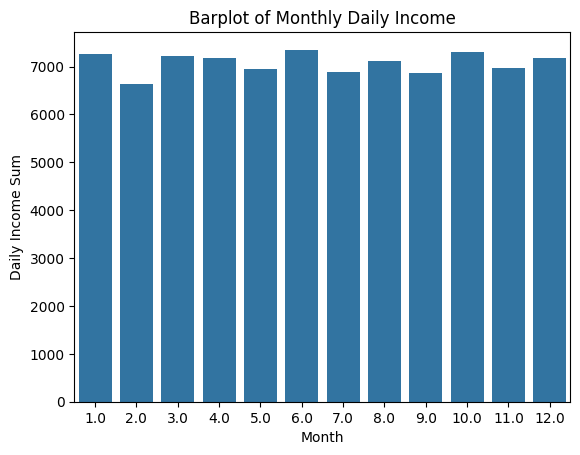

In [255]:
sns.barplot(data=month_tq, x='month', y='total')
plt.title('Barplot of Monthly Daily Income')
plt.xlabel('Month')
plt.ylabel('Daily Income Sum')
plt.show()

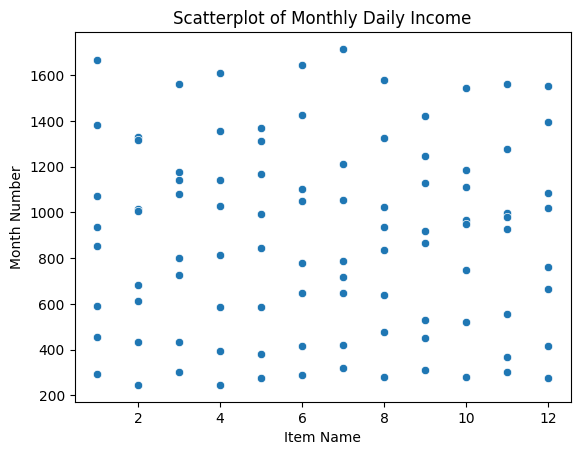

In [256]:
sns.scatterplot(data= itemonth,x='month', y='total')
plt.title('Scatterplot of Monthly Daily Income')
plt.xlabel('Item Name')
plt.ylabel('Month Number')
plt.show()

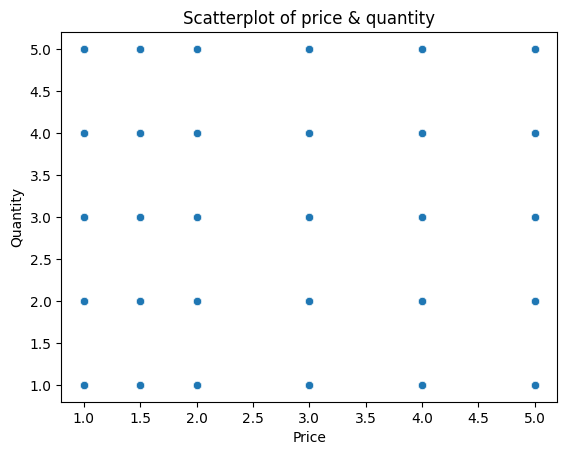

In [257]:
sns.scatterplot(data= df,x='price', y='quantity')
plt.title('Scatterplot of price & quantity')
plt.xlabel('Price')
plt.ylabel('Quantity')
plt.show()

<Axes: >

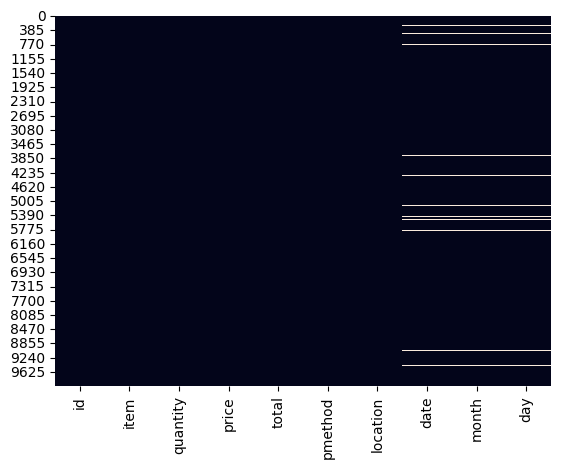

In [258]:
sns.heatmap(df.isna(), cbar=False)
